In [6]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
     -------------------------------------- 0.0/150.0 MB 660.6 kB/s eta 0:03:47
     ---------------------------------------- 0.1/150.0 MB 1.7 MB/s eta 0:01:28
     ---------------------------------------- 0.8/150.0 MB 6.5 MB/s eta 0:00:24
     ---------------------------------------- 1.6/150.0 MB 9.5 MB/s eta 0:00:16
      -------------------------------------- 2.5/150.0 MB 11.5 MB/s eta 0:00:13
      -------------------------------------- 3.3/150.0 MB 12.3 MB/s eta 0:00:12
     - ------------------------------------- 4.0/150.0 MB 12.9 MB/s eta 0:00:12
     - ------------------------------------- 4.7/150.0 MB 13.1 MB/s eta 0:00:12
     - ------------------------------------- 5.6/150.0 MB 13.8 MB/s eta 0:00:11
     - ------------------------------------- 6.1/150.0 MB 14.0 MB/s eta 0:00:11
     - ------------------------------------- 6.8/

Insight 1: Average Daily Ridership by Service Type
Local Route      9891.395203
Light Rail       7195.446298
Peak Service      179.581335
Rapid Route     12597.213243
School           2352.694995
Other              43.390411
dtype: float64

Insight 2: Average Ridership by Day of the Week
              Local Route   Light Rail  Peak Service   Rapid Route  \
Day_of_Week                                                          
Friday       12543.755474  8510.229927    202.854015  14942.156934   
Monday       11444.678832  7541.551095    235.678832  13858.824818   
Saturday      3271.156934  5000.978102      0.000000   6640.737226   
Sunday        2191.868613  3588.069343      0.000000   5053.364964   
Thursday     13166.708029  8515.218978    255.058394  15740.025547   
Tuesday      13243.072993  8591.718978    281.729927  15949.737226   
Wednesday    13378.525547  8620.357664    281.748175  15995.645985   

                  School      Other  
Day_of_Week                          
Frid

C:\Users\vigne\AppData\Local\Temp\ipykernel_20692\238518655.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_avg = df.resample('W').mean()


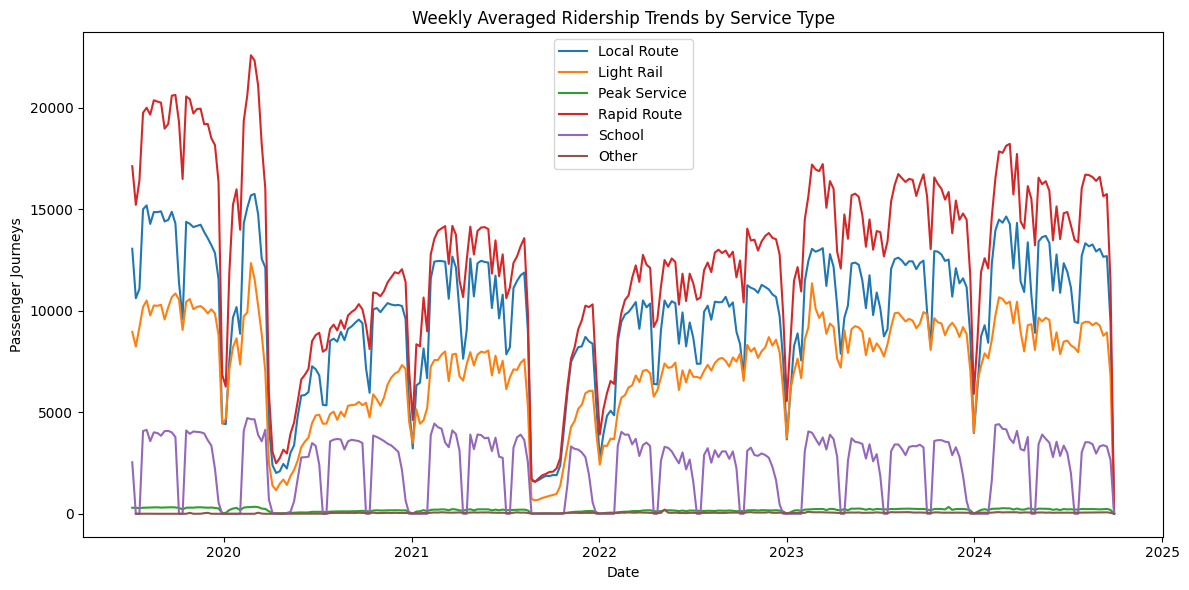

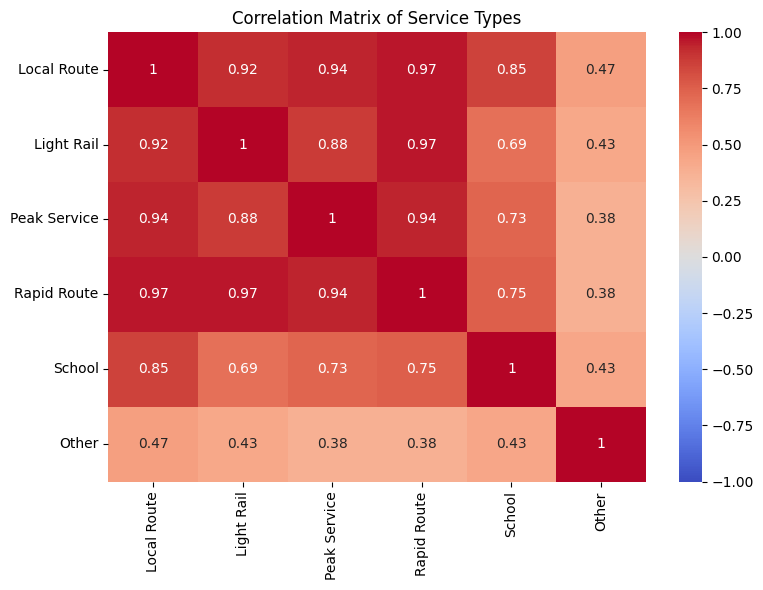

Local Route MAPE: 1.4440
Light Rail MAPE: 0.6930
Peak Service MAPE: 40222867462366160.0000
Rapid Route MAPE: 1.2924
School MAPE: 3328450754404208640.0000

Forecasts for June 4–10, 2025:
        Date  Local Route  Light Rail  Peak Service  Rapid Route  School
0 2025-06-04          NaN         NaN           NaN          NaN     NaN
1 2025-06-05          NaN         NaN           NaN          NaN     NaN
2 2025-06-06          NaN         NaN           NaN          NaN     NaN
3 2025-06-07          NaN         NaN           NaN          NaN     NaN
4 2025-06-08          NaN         NaN           NaN          NaN     NaN
5 2025-06-09          NaN         NaN           NaN          NaN     NaN
6 2025-06-10          NaN         NaN           NaN          NaN     NaN


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb                                               
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

df = pd.read_csv("Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Day_of_Week'] = df['Date'].dt.day_name()

avg_ridership = df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']].mean()
print("Insight 1: Average Daily Ridership by Service Type")
print(avg_ridership)

weekly_patterns = df.groupby('Day_of_Week')[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']].mean()
print("\nInsight 2: Average Ridership by Day of the Week")
print(weekly_patterns)

peak_days = df.groupby('Day_of_Week')[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']].max()
print("\nInsight 3: Day with Highest Ridership for Each Service")
print(peak_days.idxmax())

variability = df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']].std()
print("\nInsight 4: Ridership Variability (Standard Deviation)")
print(variability)

correlation = df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']].corr()
print("\nInsight 5: Correlation Between Service Types")
print(correlation)

df.set_index('Date', inplace=True)
weekly_avg = df.resample('W').mean()

plt.figure(figsize=(12, 6))
for column in ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']:
    plt.plot(weekly_avg.index, weekly_avg[column], label=column)
plt.title('Weekly Averaged Ridership Trends by Service Type')
plt.xlabel('Date')
plt.ylabel('Passenger Journeys')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Service Types')
plt.tight_layout()
plt.show()

df.reset_index(inplace=True)
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)
for service in ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']:
    df[f'Lag_1_{service}'] = df[service].shift(1)
    df[f'Lag_7_{service}'] = df[service].shift(7)
df = df.dropna()

future_dates = pd.date_range(start='2025-06-04', end='2025-06-10', freq='D')
future_df = pd.DataFrame({'Date': future_dates})
future_df['Day_of_Week'] = future_df['Date'].dt.dayofweek
future_df['Is_Weekend'] = future_df['Day_of_Week'].isin([5, 6]).astype(int)

def forecast_service(data, service, future_df):
    X = data[['Day_of_Week', 'Is_Weekend', f'Lag_1_{service}', f'Lag_7_{service}']]
    y = data[service]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{service} MAPE: {mape:.4f}")
    last_data = data.iloc[-1][[f'Lag_1_{service}', f'Lag_7_{service}']]
    future_features = future_df[['Day_of_Week', 'Is_Weekend']].copy()
    future_features[f'Lag_1_{service}'] = last_data[f'Lag_1_{service}']
    future_features[f'Lag_7_{service}'] = last_data[f'Lag_7_{service}']
    forecast = model.predict(future_features)
    return pd.Series(forecast, index=future_dates, name=service)

service_types = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
forecasts = pd.DataFrame({'Date': future_dates})
for service in service_types:
    forecasts[service] = forecast_service(df, service, future_df)

forecasts.to_csv('forecasts_june_4_10_2025.csv', index=False)
print("\nForecasts for June 4–10, 2025:")
print(forecasts)
